In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz
from scipy.optimize import minimize
import pandas as pd

# Function to calculate nu(t) for a given shift, s, and k
def calculate_nu(t, s, k, shift_weeks=0):
    return alpha0 + k * np.exp(-s * (np.cos(np.pi * (t - shift_weeks*7) / 365 - varphi) ** 2))

# Define time range for one year (365 days)
t_one_year = np.arange(1.0, 366.0, 1)

# Initialize parameters
alpha0 = 2.77 / 30
varphi = 0.58
s_original = 31.02  # Initial value of s
k_original = 4.51 / 30  # Initial value of k

# Generate a range of s_desired values from s_original*1/4 to s_original*2
s_desired_values = np.linspace(s_original*1/4, s_original*2, num=20)

# Create an empty list to store results
results = []
# Calculate the integral of the original curve
nu_values_original = [calculate_nu(t_day, s_original, k_original) for t_day in t_one_year]
integral_original = trapz(nu_values_original, t_one_year)
print(f'Integral for Original s={s_original}, k={k_original}: {integral_original}')

# Loop through each s_desired value, optimize, and store results
for s_desired in s_desired_values:
    # Calculate the integral of the original curve
    nu_values_original = [calculate_nu(t_day, s_original, k_original) for t_day in t_one_year]
    integral_original = trapz(nu_values_original, t_one_year)

    # Function to minimize the difference in integral
    def integral_difference(params):
        s, k = params
        nu_values = [calculate_nu(t_day, s, k) for t_day in t_one_year]
        integral = trapz(nu_values, t_one_year)
        return abs(integral - integral_original)

    # Perform optimization to find the parameters that maintain the integral
    result = minimize(integral_difference, [s_desired, k_original], bounds=((0.01, 100), (0.01, 10)))

    s_optimal, k_optimal = result.x

    # Calculate and plot the original and new birth pulses with the optimized s and k
    nu_values_new = [calculate_nu(t_day, s_optimal, k_optimal) for t_day in t_one_year]

    # Append the results to the list
    results.append({'s_desired': s_desired, 'k_optimal': k_optimal, 'integral_optimal': trapz(nu_values_new, t_one_year)})

# Create a pandas dataframe from the results list
results_df = pd.DataFrame(results)

# Print the dataframe with results
print(results_df)
s_list = list(results_df['s_desired'])
k_list = list(results_df['k_optimal'])

Integral for Original s=31.02, k=0.15033333333333332: 39.21430900858337
    s_desired  k_optimal  integral_optimal
0    7.755000   0.075211         39.214309
1   10.612105   0.087292         39.214309
2   13.469211   0.098360         39.214309
3   16.326316   0.108440         39.214309
4   19.183421   0.117719         39.214309
5   22.040526   0.126346         39.214309
6   24.897632   0.134435         39.214309
7   27.754737   0.142073         39.214309
8   30.611842   0.149325         39.214309
9   33.468947   0.156253         39.214309
10  36.326053   0.162888         39.214309
11  39.183158   0.169262         39.214309
12  42.040263   0.175404         39.214309
13  44.897368   0.181339         39.214309
14  47.754474   0.187085         39.214309
15  50.611579   0.192660         39.214309
16  53.468684   0.198077         39.214309
17  56.325789   0.203351         39.214309
18  59.182895   0.208491         39.214309
19  62.040000   0.213507         39.214309


In [3]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd  # Import Pandas
import numpy as np
from scipy import integrate
from scipy.integrate import odeint,solve_ivp
import sympy as sm
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [12, 6] #[W,H]
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import trapz
from scipy.optimize import minimize



### Model parameters from Hammed
alpha0=2.77/30 #5.12 #0.02
#alpha1=0.1
# k=4.51/30 # 55.60
# s=31.02 #26.04
varphi=0.58
Bjj=1.45e-3 # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7529244/
Bja=1.45e-3
Baa=1.45e-3
Bc=(1.45e-3)/2
rho=0.1
theta=1.05
Tj=0.0166 #0.01063829787 from https://apps.who.int/iris/bitstream/handle/10665/261080/PMC2366655.pdf?sequence=1&isAllowed=y
# The age at first litter can be regarded as 94 days
mu_j= 0.013 #0.15
mu_a=1/(50) #1/339 ()#0.01 # 0.00663571428 from https://www.jstor.org/stable/1814 R. natalensis
#the death-rate was 0.1858 per head per 28 days (0.1858/28) =  0.00663571428
gamma_j=0.0457
gamma_a=0.0457 # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7529244/
q = 0
###########

###### Time of integration ##################

t =np.arange(1.0, 366.0*2, 1)

# Model equations
def model(X, t, s, k):
    K= sum(initial) # Carrying capacity

    Sj,Ij,Cj,Rj,Sa,Ia,Ca,Ra = X #,N = X
    N = Sj+Ij+Cj+Rj+Sa+Ia+Ca+Ra
    #alpha0,k,s,phi,Bjj,Bja,Baa,Bc,Tj,mu_j,mu_a,gamma_j,gamma_a = p
    s = s
    k = k
    nu = alpha0 + k * np.exp(-s * (np.cos(np.pi * (t) / 365 - varphi) ** 2))
    #mu_j = mu_j_0+0.2+np.where(np.cos(np.pi*t/365 - varphi)**2 < 0, 0, k*np.exp(-s*(np.cos(np.pi*t/365 - varphi)**2)))
    #mu_a = mu_a_0+np.where(np.cos(np.pi*t/365 - varphi)**2 < 0, 0, k*np.exp(-s*(np.cos(np.pi*t/365 - varphi)**2)))
    ''' We add a check to make sure that the exponent is non-negative by using the np.where() function.
    The np.where() function takes two arguments: a condition and a value to return if the condition is true,
    and a value to return if the condition is false. Here we use the np.where() function to return 0
    if the exponent is negative, and k*np.exp(-s*(np.cos(np.pi*t/365 - varphi)**2)) if the exponent is non-negative.'''
    #nu = alpha0*(1+alpha1*np.sin(2*np.pi*t/365.0))


    dSjdt = nu*(Sa+Ra+(1-rho)*(Ia+Ca))-((Bja*Ia+Bjj*Ij+Bc*(Cj+Ca))*Sj)/(N**q)-Tj*Sj-mu_j*Sj * (N/(K)) #* (1-N/K)#* N/K
    #dSjdt = (nu*(Sa+Ra+(1-rho)*(Ia+Ca)))-((Bja*Ia+Bjj*Ij+Bc*(Cj+Ca))*Sj)/(N**q)-Tj*Sj-mu_j*Sj


    dIjdt = ((Bja*Ia+Bjj*Ij+Bc*(Cj+Ca))*Sj)/(N**q)-Tj*Ij-gamma_j*Ij-mu_j*Rj * (N/(K)) #* (1-N/K)#* N/K


    dCjdt = nu*(rho*(Ia+Ca))-Tj*Cj-theta*mu_j*Cj * (N/(K))#* (1-N/K)#* N/K

    dRjdt = gamma_j*Ij-Tj*Rj-mu_j*Rj * (N/(K))#* (1-N/K)#* N/K

    dSadt = Tj*Sj-((Baa*Ia+Bja*Ij+Bc*(Ca+Cj))*Sa)/(N**q)-mu_a*Sa * (N/(K))#* (1-N/K)#* N/K

    dIadt =  Tj*Ij + ((Baa*Ia+Bja*Ij+Bc*(Cj+Ca))*Sa)/(N**q)-gamma_a*Ia-mu_a*Ia * (N/(K))#* (1-N/K)#* N/K

    dCadt = Tj*Cj-theta*mu_a*Ca * (N/(K))#* (1-N/K)#* N/K

    dRadt = gamma_a*Ia+Tj*Rj-mu_a*Ra * (N/(K))#* (1-N/K)#* N/K

    #dNdt = 0.02*(N*(1-N/K)) - mu_a*N
    return [dSjdt, dIjdt, dCjdt, dRjdt, dSadt, dIadt, dCadt, dRadt]#, dNdt]# Create an array of shift values in weeks (both positive and negative)






all_results_df = pd.DataFrame()  # Create an empty DataFrame to store results

# keeping the orginal value of s and k
s_list[8] = 31.02
k_list[8] = 4.51/30
initial = []
# Loop through both s and k simultaneously
for s, k in zip(s_list, k_list):
    Sj, Ij, Cj, Rj, Sa, Ia, Ca, Ra = 500, 20, 0, 0, 200, 10, 0, 0
    initial = [Sj, Ij, Cj, Rj, Sa, Ia, Ca, Ra]

    # Simulate the model
    X = odeint(model, initial, t, args=(s, k))

    # Convert simulation results to a Pandas DataFrame
    result_df = pd.DataFrame(X, columns=['Sj', 'Ij', 'Cj', 'Rj', 'Sa', 'Ia', 'Ca', 'Ra'])

    nu = alpha0 + k * np.exp(-s * (np.cos(np.pi * (t) / 365 - varphi) ** 2))
    # Add a new column for nu value
    result_df['nu'] = nu

    # Add a new column for s value
    result_df['s'] = s

    # Add the 't' values as the first column
    result_df.insert(0, 'Time', t)

    # Append the simulation's DataFrame to the main DataFrame
    all_results_df = pd.concat([all_results_df, result_df], ignore_index=True)


# Save the results to a CSV file for easy access
#all_results_df.to_csv('simulation_variations_width_birth_pulse.csv', index=False)

# # Visualize time series for 'Sj' for different 's' values
# plt.figure(figsize=(12, 6))
# for s_value, data in data_by_s.items():
#     plt.plot(data['t'], data['Sj'], label=f's = {s_value}')

# plt.xlabel('Time (t)')
# plt.ylabel('Sj')
# plt.legend()
# plt.title('Time Series of Sj for Different s Values')
# plt.show()
all_results_df

,Time,Sj,Ij,Cj,Rj,Sa,Ia,Ca,Ra,nu,s
0,1.0,500.000000,20.000000,0.000000,0.000000,200.000000,10.000000,0.000000,0.000000,0.092645,7.755
1,2.0,469.858103,53.051602,0.144852,1.541782,189.979087,23.690690,0.001028,0.728436,0.092626,7.755
2,3.0,399.659519,124.538801,0.479281,5.325064,162.464778,53.822278,0.005774,2.444770,0.092609,7.755
3,4.0,283.196826,239.116578,1.169394,13.250554,114.250019,102.723837,0.018612,6.033071,0.092593,7.755
4,5.0,161.667985,354.724028,2.308274,26.346376,62.631926,152.550005,0.046202,12.049313,0.092579,7.755
...,...,...,...,...,...,...,...,...,...,...,...
14615,727.0,48.837907,400.858145,22.795536,456.025257,1.050182,89.619755,10.438526,319.141287,0.092333,62.040
14616,728.0,48.823919,400.839682,22.766751,455.826393,1.049913,89.638329,10.412246,319.016668,0.092333,62.040
14617,729.0,48.810870,400.818254,22.739235,455.637615,1.049672,89.655797,10.386621,318.897526,0.092333,62.040
14618,730.0,48.798709,400.794150,22.712923,455.458280,1.049457,89.672184,10.361641,318.783651,0.092333,62.040


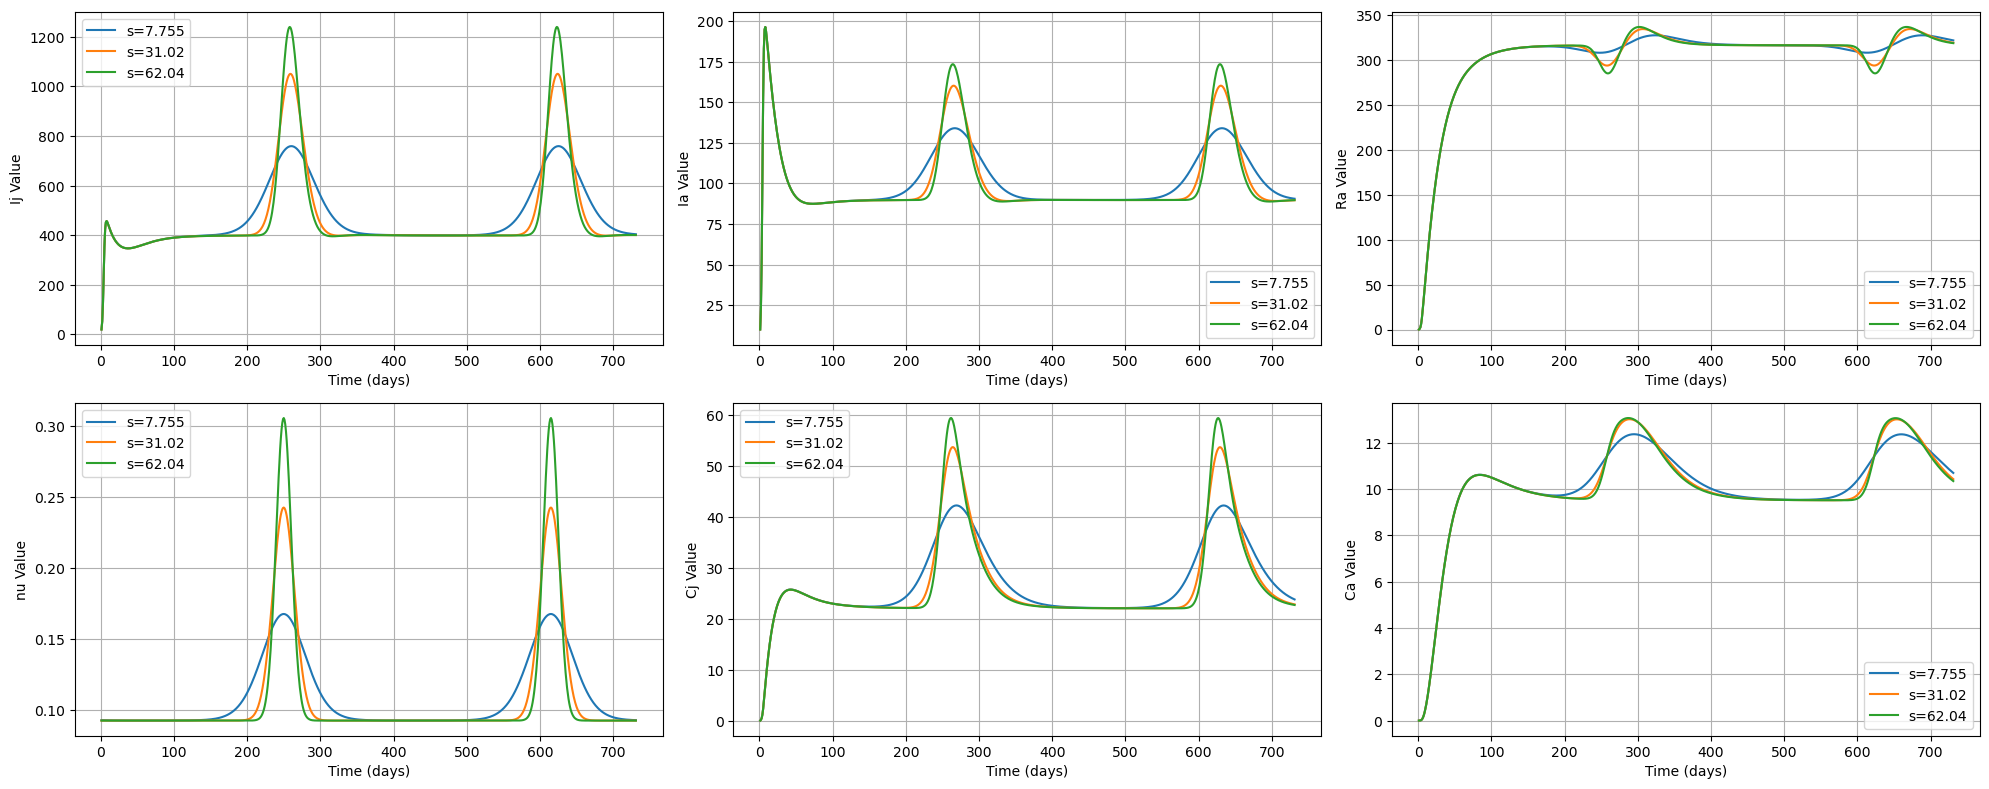

In [4]:

# Get the first, middle, and last 's' values
num_s_values = len(s_list)
first_s_value = s_list[0]
middle_s_value = s_list[8]  # Middle value for an odd-length list
last_s_value = s_list[-1]

# Filter the DataFrame for the desired 's' values
filtered_df = all_results_df[all_results_df['s'].isin([first_s_value, middle_s_value, last_s_value])]

# Create a figure with two rows and two columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))

# Group data by 's' for the filtered DataFrame
grouped_data = filtered_df.groupby('s')

# Create a plot for each 's' group for Ij in the first column (top row)
for s, group in grouped_data:
    axes[0, 0].plot(group['Time'], group['Ij'], label=f's={s}')
    axes[0, 1].plot(group['Time'], group['Ia'], label=f's={s}')
    axes[0, 2].plot(group['Time'], group['Ra'], label=f's={s}')
    axes[1, 0].plot(group['Time'], group['nu'], label=f's={s}')
    axes[1, 1].plot(group['Time'], group['Cj'], label=f's={s}')
    axes[1, 2].plot(group['Time'], group['Ca'], label=f's={s}')



# Add grids to all subplots
for ax in axes.flatten():
    ax.grid(True)

# Customize the first subplot (Ij)
axes[0, 0].set_xlabel('Time (days)')
axes[0, 0].set_ylabel('Ij Value')
#axes[0, 0].set_title('Effect of Changing "s" on Time Series (Ij)')
axes[0, 0].legend()
#xes[0, 0].grid(True)

# Customize the second subplot (Ia)
axes[0, 1].set_xlabel('Time (days)')
axes[0, 1].set_ylabel('Ia Value')
#axes[0, 1].set_title('Effect of Changing "s" on Time Series (Ia)')
axes[0, 1].legend()

# Customize the subplot (Ia)
axes[0, 2].set_xlabel('Time (days)')
axes[0, 2].set_ylabel('Ra Value')
axes[0, 2].legend()

# Customize the third subplot (nu)
axes[1, 0].set_xlabel('Time (days)')
axes[1, 0].set_ylabel('nu Value')
#axes[1, 0].set_title('Effect of Changing "s" on Time Series (nu)')
axes[1, 0].legend()

# Customize the fourth subplot (Cj)
axes[1, 1].set_xlabel('Time (days)')
axes[1, 1].set_ylabel('Cj Value')
#axes[1, 1].set_ylim(0, 15)
axes[1, 1].legend()

# Customize the subplot (Cj)
axes[1, 2].set_xlabel('Time (days)')
axes[1, 2].set_ylabel('Ca Value')
#axes[1, 2].set_ylim(0, 15)
axes[1, 2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show or save the plot
plt.show()


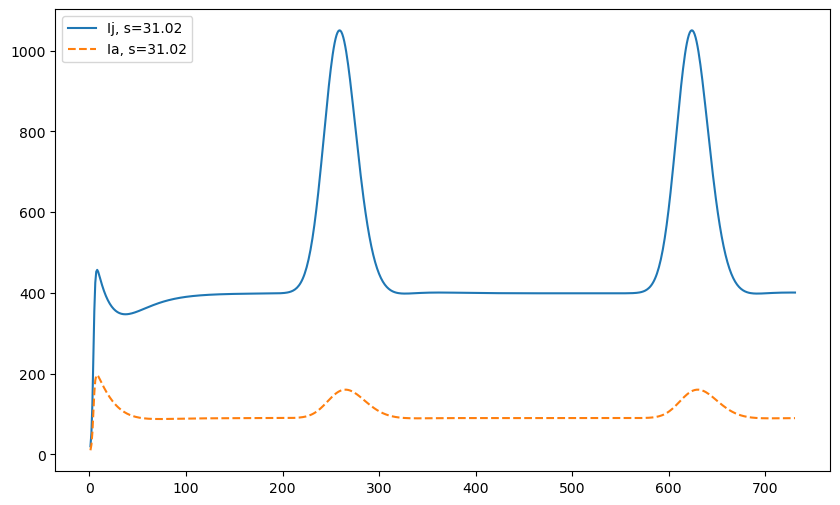

In [5]:
s_values = [middle_s_value]

fig, ax = plt.subplots(figsize=(10, 6))

for s in s_values:
    group = filtered_df[filtered_df['s'] == s]
    ax.plot(group['Time'], group['Ij'], label=f'Ij, s={s}') 
    ax.plot(group['Time'], group['Ia'], linestyle='--', label=f'Ia, s={s}')

ax.legend()
plt.show()

In [49]:
from scipy.signal import find_peaks

Ij_peaks, _ = find_peaks(group['Ij'], prominence=10)  
Ia_peaks, _ = find_peaks(group['Ia'], prominence=2)

print("Ij Peaks:", Ij_peaks)
print("Ia Peaks:", Ia_peaks)

for i, Ij_peak in enumerate(Ij_peaks):
    Ia_peak = Ia_peaks[i] 
    diff = abs(Ij_peak - Ia_peak)
    sync = 1 - diff/30 # Scale 0 to 1  
    print(f"Peak {i+1} time difference: {diff} days, Synchronicity: {sync:.3f}")

Ij Peaks: [  7 257 622]
Ia Peaks: [  7 249 614]
Peak 1 time difference: 0 days, Synchronicity: 1.000
Peak 2 time difference: 8 days, Synchronicity: 0.733
Peak 3 time difference: 8 days, Synchronicity: 0.733


In [50]:
# Initial populations
total_j = Sj+Ij+Cj+Rj
total_a = Sa+Ia+Ca+Ra

# Get Ij and Ia peak values
Ij_peaks = group['Ij'].iloc[Ij_peaks]  
Ia_peaks = group['Ia'].iloc[Ia_peaks]

for i, (Ij_peak, Ia_peak) in enumerate(zip(Ij_peaks, Ia_peaks)):

    Ij_frac = Ij_peak / total_j
    Ia_frac = Ia_peak / total_a
    
    print(f"Peak {i+1} Infected Fraction:")
    print(f"- Ij: {Ij_frac:.3f} ({Ij_peak} of {total_j} juveniles)") 
    print(f"- Ia: {Ia_frac:.3f} ({Ia_peak} of {total_a} adults)")

Peak 1 Infected Fraction:
- Ij: 0.577 (299.9909644558842 of 520 juveniles)
- Ia: 0.791 (166.01183492411388 of 210 adults)
Peak 2 Infected Fraction:
- Ij: 0.567 (294.72424666629087 of 520 juveniles)
- Ia: 0.103 (21.67453598392758 of 210 adults)
Peak 3 Infected Fraction:
- Ij: 0.566 (294.10945778847025 of 520 juveniles)
- Ia: 0.103 (21.69871005773411 of 210 adults)


In [51]:
index_14_values = all_results_df.loc[14, ['Sj', 'Ij', 'Cj', 'Rj']]
sum_values = index_14_values.sum()

print("Sum of 'Sj', 'Ij', 'Cj', 'Rj' for index 14:", sum_values)

Sum of 'Sj', 'Ij', 'Cj', 'Rj' for index 14: 344.45027606883025


In [44]:
Ij_peaks 

5855    436.677313
6105    549.673666
6470    550.045006
Name: Ij, dtype: float64

In [52]:
indexes_to_sum = [14, 257, 622]
sum_values = all_results_df.loc[indexes_to_sum, ['Sj', 'Ij', 'Cj', 'Rj']].sum(axis=1)

print("Sum of 'Sj', 'Ij', 'Cj', 'Rj' for indexes [14, 257, 622]:")
print(sum_values)


Sum of 'Sj', 'Ij', 'Cj', 'Rj' for indexes [14, 257, 622]:
14     344.450276
257    342.096883
622    341.607672
dtype: float64
